In [1]:
from itertools import combinations

import matplotlib.pyplot as plt
import random
import sys
import pandas as pd
import numpy as np

from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense, Activation, LSTM, Input, concatenate
from keras import backend as K

import tensorflow as tf
K.set_session(tf.Session())

Using TensorFlow backend.


In [27]:
risk_free = 0.01                            # 1-year risk-free rate 1%
transaction_cost = 0.0005                   # brokerage fee of 5 bps

trading_days = 250                          
gamma = 0.95
learn_rate = 0.5

Epsilon_start = 1.0                         
Epsilon_end = 0.001   
Epsilon_decay_periods = 500                # iterations over which to anneal epsilon

theta = 0.02                                # adaptation parameter of differential sharpe ratio
 
test_split_date = '2016-01-01'              # test sample includes FY2016
target_loss = 1e-2

batch_size = 64
epoch_size = 10

In [3]:
PEG = pd.read_csv('PEG.csv', parse_dates = ['Date'])
ED = pd.read_csv('ED.csv', parse_dates = ['Date'])
ES = pd.read_csv('ES.csv', parse_dates = ['Date'])
Features = pd.read_csv('features.csv', parse_dates = ['date_']).set_index('date_')

PEG['PEG'] = np.log(PEG['Adj Close']) - np.log(PEG['Adj Close'].shift(1))
ED['ED'] = np.log(ED['Adj Close']) - np.log(ED['Adj Close'].shift(1))
ES['ES'] = np.log(ES['Adj Close']) - np.log(ES['Adj Close'].shift(1))

Features['SP500_Adj_Close'] = np.log(Features['SP500_Adj_Close']) - np.log(Features['SP500_Adj_Close'].shift(1))
Features['WTI'] = np.log(Features['WTI']) - np.log(Features['WTI'].shift(1))
Features['Natural_Gas'] = np.log(Features['Natural_Gas']) - np.log(Features['Natural_Gas'].shift(1))
Features['Coal_Price'] = np.log(Features['Coal_Price']) - np.log(Features['Coal_Price'].shift(1))
Features['Uranium_Price'] = np.log(Features['Uranium_Price']) - np.log(Features['Uranium_Price'].shift(1))
Features['VIX'] = np.log(Features['VIX']) - np.log(Features['VIX'].shift(1))
Features['Electricity_NE_Price'] = np.log(Features['Electricity_NE_Price'])-np.log(Features['Electricity_NE_Price'].shift(1))
Features['Electricity_PJM_Price'] = np.log(Features['Electricity_PJM_Price'])-np.log(Features['Electricity_PJM_Price'].shift(1))
Features['Temperature'] = np.log(Features['Temperature']) - np.log(Features['Temperature'].shift(1))
Features['Wind_Speed'] = np.log(1+Features['Wind_Speed']) - np.log(1+Features['Wind_Speed'].shift(1))
Features['Precipitation'] = np.log(1+Features['Precipitation']) - np.log(1+Features['Precipitation'].shift(1))
Features['Load_Forecast'] = np.log(Features['Load_Forecast']) - np.log(Features['Load_Forecast'].shift(1))
Features.dropna(inplace=True)

PEG = PEG.set_index('Date')['PEG'].loc[Features.index]
ED = ED.set_index('Date')['ED'].loc[Features.index]
ES = ES.set_index('Date')['ES'].loc[Features.index]

Returns = pd.DataFrame([PEG, ED, ES]).T
Returns['rf'] = len(Features.index)*[np.exp(risk_free/trading_days)-1]

In [4]:
def discretize_actions(Asset_list):
    Asset_combinations = []
    for i in range(1, len(Asset_list)+1):
        Asset_combinations.extend(combinations(Asset_list, i))

    Actions = []
    for Asset_combination in Asset_combinations:
        Action = dict((a, 0) for a in Asset_list)
        for a in Asset_combination:
            Action[a] = 1/len(Asset_combination)
        Actions.append(Action)

    return pd.DataFrame(Actions)

In [5]:
def differential_sharpe_ratio(R1, A0, B0, theta):   
    dA1 = R1 - A0
    dB1 = R1**2 - B0
    
    A1 = A0 + theta*dA1
    B1 = B0 + theta*dB1
    
    if ((B0 - A0**2) != 0):
        D1 = (B0*dA1 - 0.5*A0*dB1) / ((B0 - A0**2)**(3/2))
    else:
        D1 = 0
    
    return D1, A1, B1

In [6]:
def DRQN(rnn_layers, n_unobserved, n_observed, n_actions):

    unobserved_input = Input(shape=(1, n_unobserved), name='unobserved_input')
    unobserved_states = LSTM(rnn_layers)(unobserved_input)

    observed_input = Input(shape=(n_observed, ), name='observed_input')
    observed_states = Dense(n_observed, activation='relu')(observed_input)
    
    first_layer = concatenate([unobserved_states, observed_states])
    second_layer = Dense(n_actions, activation='relu')(first_layer)
    output_layer = Dense(n_actions, activation='relu', name='output_layer')(second_layer)
    
    model = Model(inputs=[unobserved_input, observed_input], outputs=[output_layer])
    return model

In [77]:
# Discretization of actions
Asset_list = list(Returns.columns)
Actions = discretize_actions(Asset_list)

# Initialization of Q-network
rnn_layers = 5
n_unobserved = len(Features.columns)
n_observed = len(Actions.columns)
n_actions = len(Actions.index)
n_samples = len(Features.index)

model = DRQN(rnn_layers, n_unobserved, n_observed, n_actions)
try:
    model.load_weights("model.h5")
    iter_num = np.load('iteration.npy').item()
    losses = list(np.load('losses.npy'))
    print ("Model parameters has been loaded")    
except:
    iter_num = 0
    losses = []
adam = Adam()
model.compile(loss='mse', optimizer=adam)

# Q-learning
train_samples_num = len(Features[Features.index < test_split_date].index)
proceed = True

while (proceed):
    
    # Epsilon decay
    Epsilon = Epsilon_start + (Epsilon_end - Epsilon_start) * min(iter_num / Epsilon_decay_periods, 1)
    
    # Forming training sample
    last_state = Actions.loc[len(Returns.columns)-1]
    A0, B0 = risk_free, risk_free**2
    a_list, target_list = [], []
    loss = 0
    
    for i in range(train_samples_num-1):
        Q_targets = model.predict({'unobserved_input': Features.iloc[i].values.reshape((1, 1, len(Features.iloc[i]))), 
                                   'observed_input': last_state.values.reshape((1, len(last_state)))})
        Q_targets = Q_targets[0]
        
        # Epsilon greedy choice of action
        if (random.random() < Epsilon):
            a1_index = random.choice(Actions.index)
            a1 = Actions.loc[a1_index]
        else:
            a1_index = np.argmax(Q_targets)
            a1 = Actions.loc[a1_index]
        
        # Calculating current period portfolio return
        delta_weights = abs(a1 - last_state)
        transaction_costs = transaction_cost*delta_weights 
        portfolio_returns = np.multiply(a1, Returns.iloc[i])
        r = np.sum(portfolio_returns - transaction_costs)
        
        # Calculating differential sharpe ratio
        D1, A0, B0 = differential_sharpe_ratio(r, A0, B0, theta)   
        
        # Calculating target value of Q-function
        Q1 = model.predict({'unobserved_input': Features.iloc[i+1].values.reshape((1, 1, len(Features.iloc[i+1]))), 
                            'observed_input': a1.values.reshape((1, len(a1)))})
        Q1 = Q1[0]
        Q_new = D1 + gamma * np.max(Q1)
        loss += abs(Q_new - Q_targets[a1_index])
        Q_targets[a1_index] = (1-learn_rate)*Q_targets[a1_index] + learn_rate*Q_new
        
        # Appending training sample
        target_list.append(Q_targets)
        a_list.append(list(last_state))
        last_state = a1.copy()
    
    # Updating Q-network
    train_features = Features.iloc[:train_samples_num-1]
    train_features = train_features.values.reshape((train_features.shape[0], 1, train_features.shape[1]))
    model.fit({'unobserved_input': train_features, 
               'observed_input': np.array(a_list)},
               np.array(target_list),
               batch_size=batch_size, epochs=epoch_size, shuffle=False, verbose=0)
    
    # Parameters of next iteration
    losses.append(loss)
    if (loss < target_loss):
        proceed = False
    iter_num += 1
    
    # Saving model every 10 iterations
    if (iter_num % 10 == 0):
        model.save_weights("model.h5", overwrite=True)
        np.save('iteration.npy', iter_num)
        np.save('losses.npy', losses)
        print ('Iteration ' + str(iter_num) + '. Loss ' + str(loss) + '.')

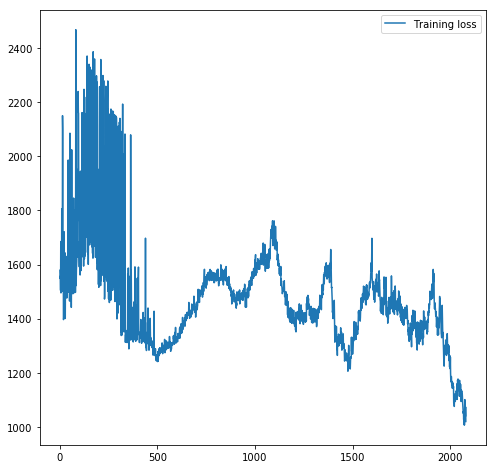

In [79]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(range(1, iter_num+1), losses, label = "Training loss")
ax.legend()
plt.show()

In [80]:
test_portfolio_r = []
test_benchmark_r = []
last_state = Actions.loc[len(Returns.columns)-1]

for i in range(train_samples_num, n_samples):
    
    # Choosing best action
    Q_targets = model.predict({'unobserved_input': Features.iloc[i].values.reshape((1, 1, len(Features.iloc[i]))), 
                               'observed_input': last_state.values.reshape((1, len(last_state)))})
    Q_targets = Q_targets[0]
    a1_index = np.argmax(Q_targets)
    a1 = Actions.loc[a1_index]

    # Calculating current period portfolio return
    delta_weights = abs(a1 - last_state)
    transaction_costs = transaction_cost*delta_weights 
    portfolio_returns = np.multiply(a1, Returns.iloc[i])
    r = np.sum(portfolio_returns - transaction_costs)

    # Appending observed returns
    test_portfolio_r.append(r)
    test_benchmark_r.append(np.mean(Returns.iloc[i]))

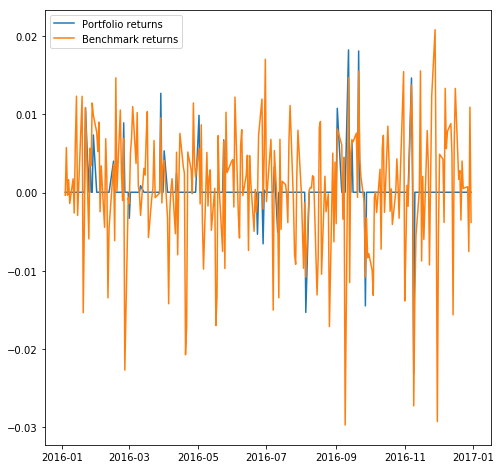

In [84]:
test_portfolio_r = pd.Series(test_portfolio_r)
test_benchmark_r = pd.Series(test_benchmark_r)
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(Returns.iloc[train_samples_num:].index, test_portfolio_r, label = 'Portfolio returns')
ax.plot(Returns.iloc[train_samples_num:].index, test_benchmark_r, label = 'Benchmark returns')
ax.legend()
plt.show()

In [85]:
portfolio_total_return = np.prod(1+test_portfolio_r)-1
benchmark_total_return = np.prod(1+test_benchmark_r)-1

portfolio_std = np.std(test_portfolio_r)*np.sqrt(len(test_portfolio_r))
benchmark_std = np.std(test_benchmark_r)*np.sqrt(len(test_benchmark_r))

portfolio_sharpe_ratio = (portfolio_total_return - risk_free)/portfolio_std
benchmark_sharpe_ratio = (benchmark_total_return - risk_free)/benchmark_std

print('Return of the actively managed portfolio', round(100*portfolio_total_return,2), '%')
print('Return of the benchmark', round(100*benchmark_total_return,2), '%')
print()
print('Sharpe ratio of the actively managed portfolio', round(portfolio_sharpe_ratio,2))
print('Sharpe ratio of the benchmark', round(benchmark_sharpe_ratio,2))

Return of the actively managed portfolio 8.43 %
Return of the benchmark 11.23 %

Sharpe ratio of the actively managed portfolio 1.42
Sharpe ratio of the benchmark 0.81
